In [1]:
import time
import pandas as pd
import re
import datetime

In [2]:
# load the csv file into a pandas dataframe
df = pd.read_csv("discord_channel_messages.csv")
df

FileNotFoundError: [Errno 2] No such file or directory: 'discord_channel_messages.csv'

In [17]:
# load the csv file into a pandas dataframe
df = pd.read_csv("discord_channel_messages.csv")

# drop author column
df.drop(columns=['author'], inplace=True)

# Split column content
# Victim: before the first " got killed by "
# Killer: between " got killed by " and " "
# Meter: after ", " and before "m)"

df['Victim'] = df['content'].str.extract(r'^(.*?) got killed by ')

# if Victim contains "Survivor (<any number>)" set the String to "User"
df['Victim'] = df['Victim'].str.replace(r'Survivor \(\d+\)', 'User', regex=True)


# tmp: everything after 'got killed by '
df['tmp2'] = df['content'].str.split('got killed by ').str[1]


df['Meter'] = df['content'].str.extract(r', (.*?)m\)')

# TMP: reverse the order of the characters in colmn content
df['tmp'] = df['content'].str[::-1]
# keep everything after the first " ," 
df['tmp'] = df['tmp'].str.split(' ,').str[1]
# remove everything behind the first "( " with regex
df['tmp'] = df['tmp'].str.replace(r'\(.*', '', regex=True)
# reverse the order of the characters in column tmp again
df['Weapon'] = df['tmp'].str[::-1]
# split the column tmp2 by " (". Sometimes there are two " (" in the column in this case we combine [0] and [1]
df['Killer'] = df['tmp2'].str.split(' \(').str[0]
# drop the column tmp2
df.drop(columns=['tmp'], inplace=True)
df.drop(columns=['tmp2'], inplace=True)


# drop the column content
df.drop(columns=['content'], inplace=True)

# create column date and column time from the column timestamp
df['date'] = pd.to_datetime(df['timestamp']).dt.date
df['time'] = pd.to_datetime(df['timestamp']).dt.time
# drop the column timestamp
df.drop(columns=['timestamp'], inplace=True)

df['date'] = pd.to_datetime(df['date'])

# remove everything behind . of colum time
df['time'] = df['time'].astype(str).str.split('.').str[0]

#df['time'] = pd.to_datetime(df['time'], format='%H:%M:%S').dt.time
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d').dt.date

# drop duplicate rows
df.drop_duplicates(inplace=True)

#  cast m to number
df['Meter'] = df['Meter'].str.replace('m', '').astype(float)

df

,Victim,Meter,Weapon,Killer,date,time
0,Kaidan,51.53,KA-M,MrFahrenheit,2025-04-01,20:00:20
1,Patmus,7.75,KA-M,MrFahrenheit,2025-04-01,20:01:43
2,Friend,1.12,Mlock-91,LaC0,2025-04-01,20:26:19
3,Apian,3.07,DMR,[BuZz] John Pork,2025-04-01,20:52:08
4,Anthony Caponi,31.45,KA-101,JasonBjoern,2025-04-01,21:31:22
...,...,...,...,...,...,...
2395,Cateye,240.43,Blaze,Silent,2024-12-18,20:34:30
2396,Boris,96.52,VSD,TEEG,2024-12-18,20:39:54
2397,User,5.53,Vikhr,TEEG,2024-12-18,20:46:13
2398,SUTRIONS,17.35,VSD,TEEG,2024-12-18,20:46:43


In [18]:
# visualize the data
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style of seaborn
sns.set(style="whitegrid", palette="pastel", font_scale=1.2)


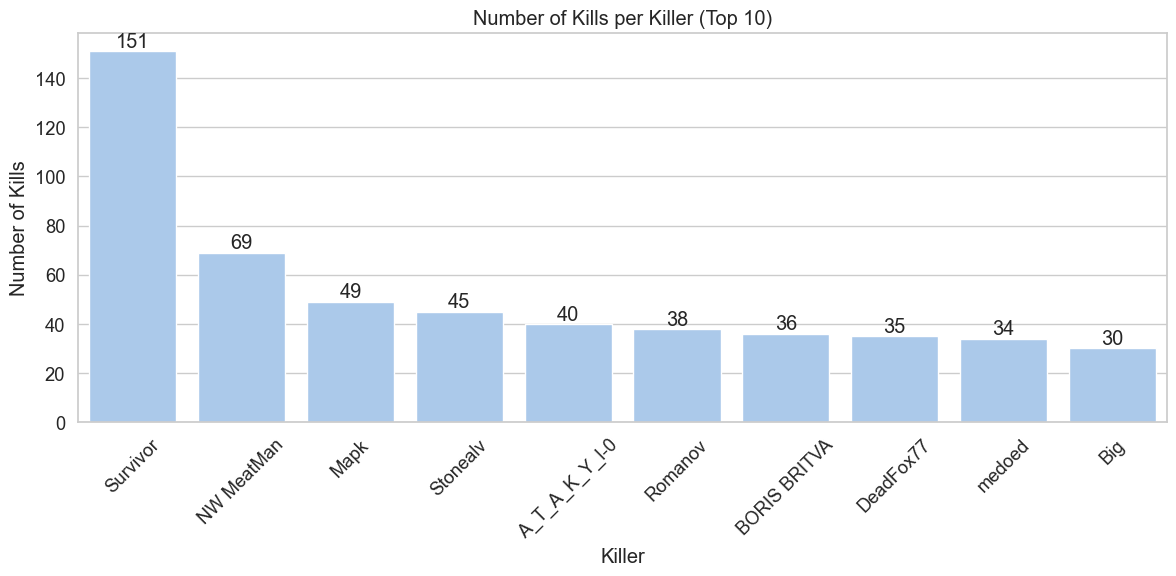

In [19]:
# Create a count plot of the number of kills per killer (top 10)
plt.figure(figsize=(12, 6))
top_10_killers = df['Killer'].value_counts().head(10).index
sns.countplot(data=df[df['Killer'].isin(top_10_killers)], x='Killer', order=top_10_killers)
plt.title('Number of Kills per Killer (Top 10)')
plt.xlabel('Killer')
plt.ylabel('Number of Kills')
plt.xticks(rotation=45)

# Add labels to the bars
for container in plt.gca().containers:
    plt.gca().bar_label(container, fmt='%d', label_type='edge')

plt.tight_layout()
plt.show()


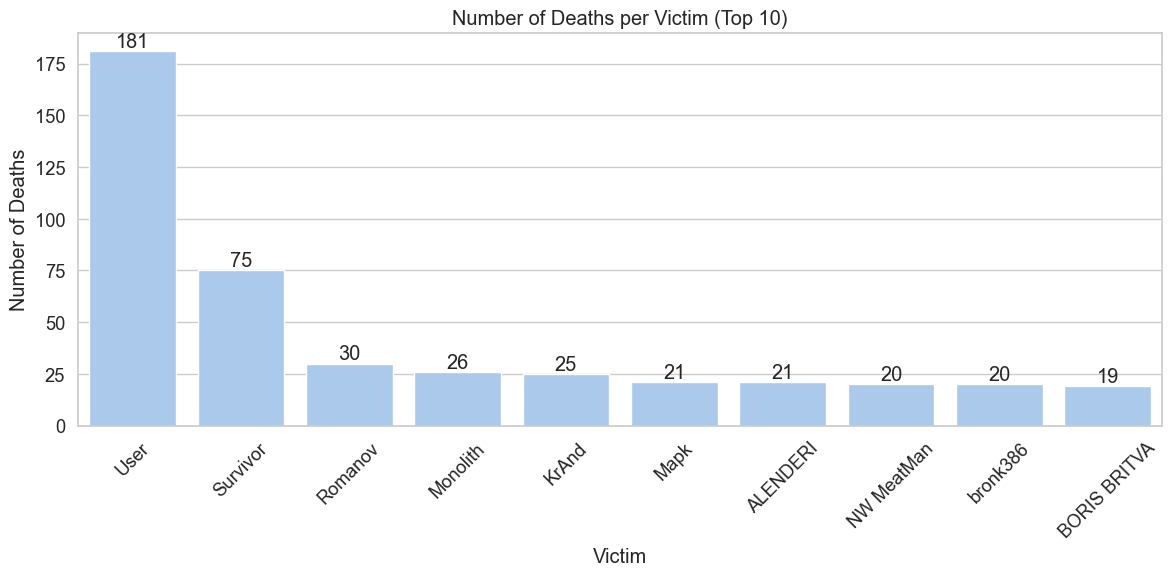

In [20]:
# Create a count plot of the number of kills per victim (top 10)
plt.figure(figsize=(12, 6))
top_10_victims = df['Victim'].value_counts().head(10).index
sns.countplot(data=df[df['Victim'].isin(top_10_victims)], x='Victim', order=top_10_victims)
plt.title('Number of Deaths per Victim (Top 10)')
plt.xlabel('Victim')
plt.ylabel('Number of Deaths')
plt.xticks(rotation=45)

# Add labels to the bars
for container in plt.gca().containers:
    plt.gca().bar_label(container, fmt='%d', label_type='edge')

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np  # for simple mathematics

# Code for Df with Kills und Deaths per Player
all_players = pd.concat([df['Killer'], df['Victim']]).unique()
kd_df = pd.DataFrame({
    'Name': all_players,
    'Kills': pd.Series(all_players).map(df['Killer'].value_counts()).fillna(0).astype(int),
    'Deaths': pd.Series(all_players).map(df['Victim'].value_counts()).fillna(0).astype(int)
})

# add KDR
kd_df['KDR'] = np.where(
    kd_df['Deaths'] > 0,  # Nur teilen, wenn Deaths > 0
    kd_df['Kills'] / kd_df['Deaths'],  # Kills/Deaths
    kd_df['Kills']  # Wenn Deaths=0, setze KDR = Kills
)

# round to 2 decimal numbers
kd_df['KDR'] = kd_df['KDR'].round(2).astype(float)

# sort the results
kd_df = kd_df.sort_values('KDR', ascending=False).reset_index(drop=True)

print(kd_df.head(50))

In [ ]:
kd_buzz = kd_df[kd_df['Name'].str.contains('BuZz|Mampfo', case=False)]
kd_buzz.reset_index(drop=True, inplace=True)
kd_buzz.head(6)

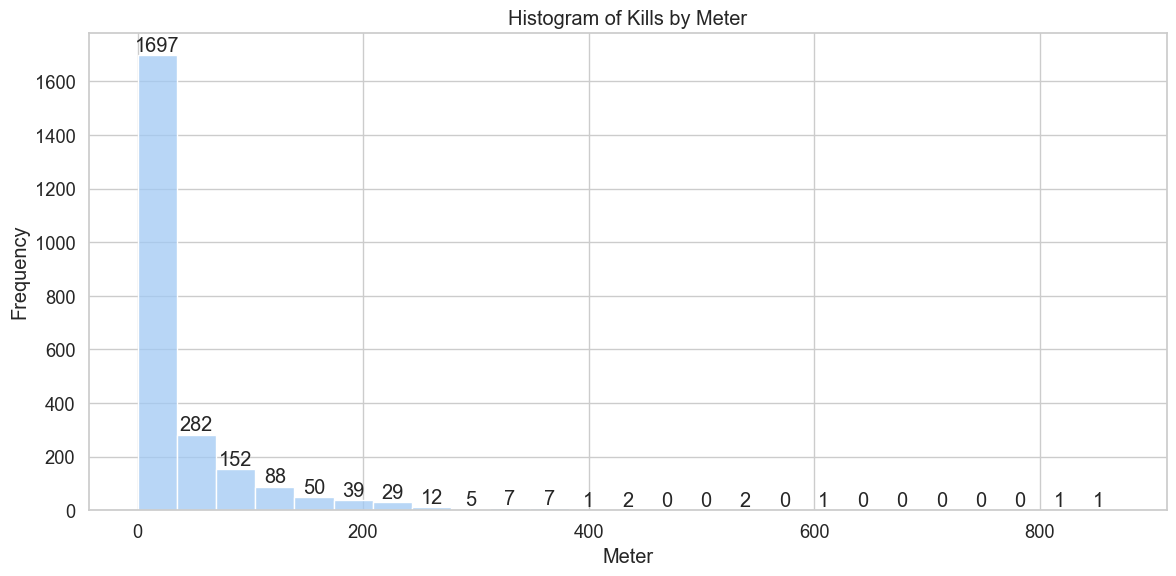

In [21]:
# Create a histogram for the Meter column with automatic bins
plt.figure(figsize=(12, 6))
ax = sns.histplot(data=df, x='Meter', bins=25, kde=False)
plt.title('Histogram of Kills by Meter')
plt.xlabel('Meter')
plt.ylabel('Frequency')

# Add labels to the bars
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge')

plt.tight_layout()
plt.show()


In [22]:
# table of the top 10 kills by meter
top_10_kills_by_meter = df.nlargest(10, 'Meter')
top_10_kills_by_meter.reset_index(drop=True, inplace=True)
top_10_kills_by_meter


,Victim,Meter,Weapon,Killer,date,time
0,Reinhart Beinhart,868.96,DMR,Darkness,2025-03-24,18:38:25
1,Mr.Freeman,812.79,DMR,[BuZz] John Pork,2025-04-04,18:57:39
2,pork,604.89,M70 Tundra,chste043,2025-02-22,17:24:00
3,Rabbit,538.78,VSD,NW MeatMan,2025-01-07,19:40:33
4,Flow_EZGG,528.79,VSD,NW MeatMan,2025-01-07,19:34:48
5,Dahmer,442.75,CR-550 Savanna,Tom,2025-01-20,01:02:56
6,PoTiS,436.79,VS-89,PussyDestroyer,2025-03-05,00:06:53
7,CrayonEater,398.15,Blaze,A_T_A_K_Y_l-0,2025-03-03,20:07:58
8,[SMRF]Banderivets,381.10,VSD,Blind Boris,2025-01-11,21:02:13
9,Zherion,372.49,M70 Tundra,-Dragon-,2024-12-31,12:50:06


In [23]:
# Average kill distance per Weapon
average_kill_distance = df.groupby('Weapon')['Meter'].mean().reset_index()
average_kill_distance.rename(columns={'tmp': 'Weapon', 'Meter': 'Average Distance (m)'}, inplace=True)
average_kill_distance.sort_values(by='Average Distance (m)', ascending=False, inplace=True,)
average_kill_distance['Average Distance (m)'] = average_kill_distance['Average Distance (m)'].round(2)
average_kill_distance.reset_index(drop=True, inplace=True)


# add max kill distance to the table
max_kill_distance = df.groupby('Weapon')['Meter'].max().reset_index()
max_kill_distance.rename(columns={'tmp': 'Weapon', 'Meter': 'Max Distance (m)'}, inplace=True)
max_kill_distance.sort_values(by='Max Distance (m)', ascending=False, inplace=True)
max_kill_distance.reset_index(drop=True, inplace=True)
# merge the two tables
average_kill_distance = pd.merge(average_kill_distance, max_kill_distance, on='Weapon')

average_kill_distance.head(10)

,Weapon,Average Distance (m),Max Distance (m)
0,CR-550 Savanna,131.23,442.75
1,M70 Tundra,115.01,604.89
2,VS-89,104.81,436.79
3,DMR,86.13,868.96
4,VSD,83.98,538.78
5,Blaze,80.75,398.15
6,Mosin 91/30,66.06,253.16
7,Pioneer,60.39,176.86
8,CR-527,46.75,222.67
9,LAR,45.53,236.36


In [24]:
# all kills with weapon "Potato"
potato_kills = df[df['Weapon'] == 'Potato']
potato_kills

,Victim,Meter,Weapon,Killer,date,time
8,B1100110011,0.89,Potato,[Gr0b]youGamElling!0.o,2025-04-02,19:50:59


In [25]:
# Top weapons by kill count with average distance
top_weapons_by_kill_count = df['Weapon'].value_counts().reset_index()
top_weapons_by_kill_count.columns = ['Weapon', 'Kill Count']
top_weapons_by_kill_count.reset_index(drop=True, inplace=True)

# Merge with average kill distance
top_weapons_with_avg_distance = top_weapons_by_kill_count.merge(
    average_kill_distance, on='Weapon', how='left'
)

# Sort by kill count and display the top 10
top_weapons_with_avg_distance.sort_values(by='Kill Count', ascending=False, inplace=True)
top_weapons_with_avg_distance.head(10)


,Weapon,Kill Count,Average Distance (m),Max Distance (m)
0,KA-74,241,13.32,169.67
1,M4-A1,158,28.52,369.33
2,M70 Tundra,146,115.01,604.89
3,KA-M,136,13.86,78.98
4,DMR,122,86.13,868.96
5,Blaze,103,80.75,398.15
6,VSD,96,83.98,538.78
7,LAR,89,45.53,236.36
8,KA-101,81,14.86,97.29
9,VS-89,75,104.81,436.79


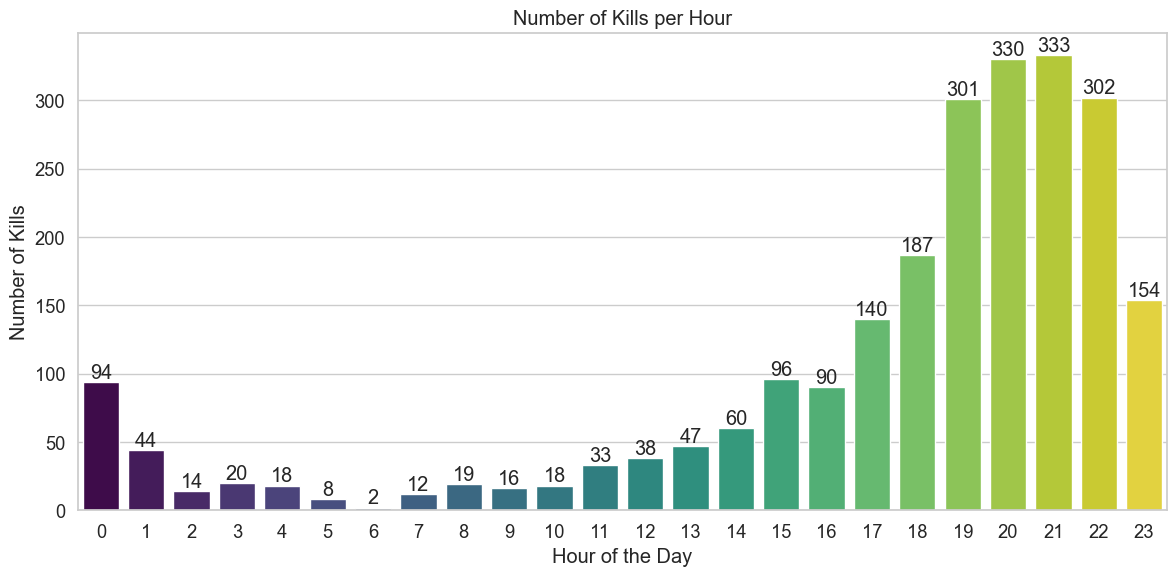

In [26]:
# visualize the time and frequency of kills per hour
plt.figure(figsize=(12, 6))
# Convert the 'time' column to datetime format for easier manipulation
df['time'] = pd.to_datetime(df['time'], format='%H:%M:%S').dt.time
# Create a new column for the hour of the kill
df['hour'] = pd.to_datetime(df['time'], format='%H:%M:%S').dt.hour
# Create a count plot of the number of kills per hour
sns.countplot(data=df, x='hour',hue='hour', palette='viridis', legend=False)
plt.title('Number of Kills per Hour') 
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Kills')
# Add labels to the bars
for container in plt.gca().containers:
    plt.gca().bar_label(container, fmt='%d', label_type='edge')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [27]:
# top 5 killer with the text "BuZz" in their name
top_5_killers_buzz = df[df['Killer'].str.contains('BuZz', case=False)]['Killer'].value_counts().head(5).reset_index()
top_5_killers_buzz.columns = ['Killer', 'Kill Count']
top_5_killers_buzz.reset_index(drop=True, inplace=True)
top_5_killers_buzz.head(5)

,Killer,Kill Count
0,[BuZz] John Pork,7
1,[BuZz] taubenschreck,4
2,[BuZz] Bratan Joseph,2
3,[BuZz] Luca,1


In [28]:
# list all kills with the text "BuZz" in their name
kills_buzz = df[df['Killer'].str.contains('BuZz', case=False)]
kills_buzz.reset_index(drop=True, inplace=True)
# reorder the columns
kills_buzz = kills_buzz[['Killer', 'Victim', 'Weapon', 'Meter', 'date', 'time']]
kills_buzz.head(50)

,Killer,Victim,Weapon,Meter,date,time
0,[BuZz] John Pork,Apian,DMR,3.07,2025-04-01,20:52:08
1,[BuZz] John Pork,Mango,DMR,4.39,2025-04-03,21:39:31
2,[BuZz] John Pork,Fupp,DMR,21.35,2025-04-03,21:49:08
3,[BuZz] John Pork,Mr.Freeman,DMR,812.79,2025-04-04,18:57:39
4,[BuZz] taubenschreck,Survivor,DMR,213.34,2025-03-31,20:38:57
5,[BuZz] taubenschreck,McLovin,M4-A1,7.06,2025-03-26,22:10:14
6,[BuZz] taubenschreck,DonCorleone,M4-A1,5.26,2025-03-26,22:15:15
7,[BuZz] taubenschreck,V,M4-A1,2.17,2025-03-26,22:15:52
8,[BuZz] John Pork,janithawelp,DMR,12.79,2025-03-23,21:23:23
9,[BuZz] John Pork,terminator_Polska3,DMR,225.47,2025-03-18,20:32:36
